In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import matplotlib as mpl
import astropy.units as u
from asteria.stellardist import StellarDensity
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize

In [2]:
def diff(x, r):
    diff = np.abs(Dist2Rate(x) - r)
    return float(diff)

def Dist2Rate(d):
    return sd_ccsn_rate(d)

def Rate2Dist(r_in):
    if not isinstance(r_in, np.ndarray):
        if r_in > sd_ccsn_tot_rate:
            r_in = sd_ccsn_tot_rate
        res = minimize(diff, x0=10, args=r_in)
        return res.x
    else:
        np.where(r_in>sd_ccsn_tot_rate,sd_ccsn_tot_rate,r_in)
        r_out = []
        for rr in r_in:
            res = minimize(diff, x0=10, args=rr)
            r_out.append(res.x)
        r_out = np.array(r_out)
        return r_out
    
def diff_cdf(x, cdf_val):
    if x > 25 + 1E-3: #everything above 25 kpc has a probability of 100%, but we want the 'edge' so we punish any
        # value that is higher than 25 kpc + epsilon, epsilon << 1
        return 1E6
    else:
        diff = np.abs(sd_cdf(x) - cdf_val)
        return float(diff)
    
def inv_cdf(cdf_val):
    if not isinstance(cdf_val, np.ndarray):
        res = minimize(diff_cdf, x0 = 5, args=cv)
        return res.x
    else:
        d = []
        for cv in cdf_val:
            loss, i = 1, 0
            x0s = np.array([5,10,15,20])
            while loss > 1E-3:
                res = minimize(diff_cdf, x0 = x0s[i], args=cv)
                loss = res.fun
                i += 1
                if i > 3:
                    print('Fit failed to converge!')
                    break
            d.append(res.x)
        d = np.array(d)
        return d
    
def MSE(v):
    return np.sqrt(np.sum((func(v)-sig)**2))

In [3]:
stime = "indep" # "dep", "indep"
sfreq = "indep" # "dep", "indep"

smix = "NoTransformation" # "NoTransformation", "CompleteExchange", "AdiabaticMSW"
shier = "normal" # "normal", "inverted"
smodel = "Tamborra_2014_20M" # "Tamborra_2014_11M", "Tamborra_2014_20M", "Tamborra_2014_27M"
sdir = 1

filename1 = './files/freq_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2.pkl'
filename2 = './files/freq_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2+WLS.pkl'


file1 = open(filename1, 'rb')
data1 = pickle.load(file1)
file2 = open(filename2, 'rb')
data2 = pickle.load(file2)

distances1, Sts1_gen2, Sts1_ic86, Bts1_gen2, Bts1_ic86, Z1_gen2, Z1_ic86 = data1
distances2, Sts2_gen2, Sts2_ic86, Bts2_gen2, Bts2_ic86, Z2_gen2, Z2_ic86 = data2

In [4]:
# stellar distribution file, Adams 2013 model, returns CDF
sd = StellarDensity('../../../../data/stellar/sn_radial_distrib_adams.fits', add_LMC=False, add_SMC=False)

dmax = np.max((distances1,distances2))*u.kpc
sd_cdf = PchipInterpolator(sd.dist.value, sd.cdf)

In [5]:
#interpolations of the significance data
d = 7 * u.kpc
sig_wls_50 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[0])
sig_gen2_50 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[0])
sig_ic86_50 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[0])

sig_wls_14 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[1])
sig_gen2_14 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[1])
sig_ic86_14 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[1])

sig_wls_86 = PchipInterpolator(distances1[distances1>d], Z2_gen2[distances1>d].T[2])
sig_gen2_86 = PchipInterpolator(distances1[distances1>d], Z1_gen2[distances1>d].T[2])
sig_ic86_86 = PchipInterpolator(distances1[distances1>d], Z1_ic86[distances1>d].T[2])

sd_ccsn = PchipInterpolator(sd.dist.value, sd.cdf)

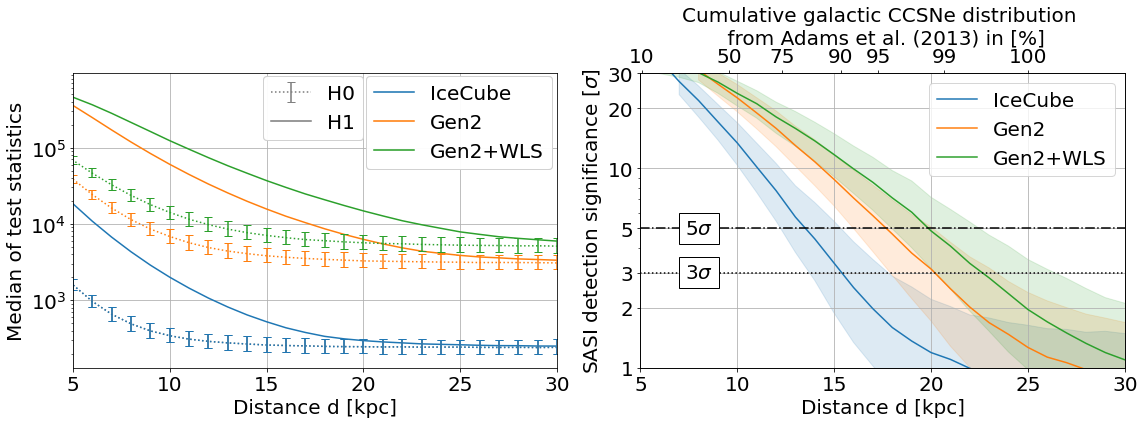

In [6]:
fig, ax = plt.subplots(1,2, figsize = (16,6))
ax = ax.ravel()
fs = 20

ax[1].plot(distances1, Z1_ic86.T[0], color = 'C0', label='IceCube')
ax[1].plot(distances1, Z1_gen2.T[0], color = 'C1', label='Gen2')
ax[1].plot(distances1, Z2_gen2.T[0], color = 'C2', label='Gen2+WLS')

ax[1].fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C0')
ax[1].fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax[1].fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C2')

ax[1].set_xlabel('Distance d [kpc]', fontsize = fs)
ax[1].set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = fs)
ax[1].set_xlim((5,30))
ax[1].set_ylim((1,30))

ax[1].tick_params(labelsize = fs)

ax[1].set_yscale('log')
ax[1].set_xticks([5,10,15,20,25,30])
ax[1].set_xticklabels(['5','10','15','20','25','30'])
ax[1].set_yticks([1,2,3,5,10,20,30])
ax[1].set_yticklabels(['1','2','3','5','10','20','30'])

ax[1].grid()
ax[1].legend(loc='upper right', fontsize = fs)

ax[1].axhline(3, color='k', ls = ':')
ax[1].axhline(5, color='k', ls = '-.')
ax[1].text(8, 3, r"3$\sigma$", size=fs,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax[1].text(8, 5, r"5$\sigma$", size=fs,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax[1].twiny()
ax22.set_xlim(ax[1].get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = fs)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = fs)

#signal without errorbar
p0, = ax[0].plot(0, Sts1_ic86.T[0][0], color = 'grey', label='H1')
p1, = ax[0].plot(distances1, Sts1_ic86.T[0], color = 'C0', label='IceCube')
p2, = ax[0].plot(distances1, Sts1_gen2.T[0], color = 'C1', label='Gen2')
p3, = ax[0].plot(distances2, Sts2_gen2.T[0], color = 'C2', label='Gen2+WLS')

#background with errorbar
p4 = ax[0].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'grey', ls = ':', label='H0')
ax[0].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label=r'TS$^{bkg}_{IceCube}$')
ax[0].errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = ':', label=r'TS$^{bkg}_{Gen2}$')
ax[0].errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = ':', label=r'TS$^{bkg}_{Gen2+WLS}$')

#rearrange legend handels
handles,labels = ax[0].get_legend_handles_labels()

handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]

ax[0].set_xticks([5,10,15,20,25,30])
ax[0].set_xticklabels(['5','10','15','20','25','30'])
ax[0].set_xlabel('Distance d [kpc]', fontsize = fs)
ax[0].set_ylabel('Median of test statistics', fontsize = fs)
ax[0].set_xlim((5,30))
ax[0].set_yscale('log')
ax[0].tick_params(labelsize = fs)
#ax[0].legend(handles, labels, ncol = 3, fontsize = fs, bbox_to_anchor=(0.13, 1))
ax[0].grid()


l1 = fig.legend([p1, p2, p3], ['IceCube','Gen2', 'Gen2+WLS'], numpoints=1, 
                handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=fs, loc = (0.32,0.6))
l1 = plt.gca().add_artist(l1)
l2 = fig.legend([p4, p0], ['H0', 'H1'], numpoints=1,
               handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=fs , loc = (0.23,0.668))
l2 = plt.gca().add_artist(l2)



plt.tight_layout()

filename = './plots/result_taup.pdf'
plt.savefig(filename, dpi = 200, facecolor = 'white')

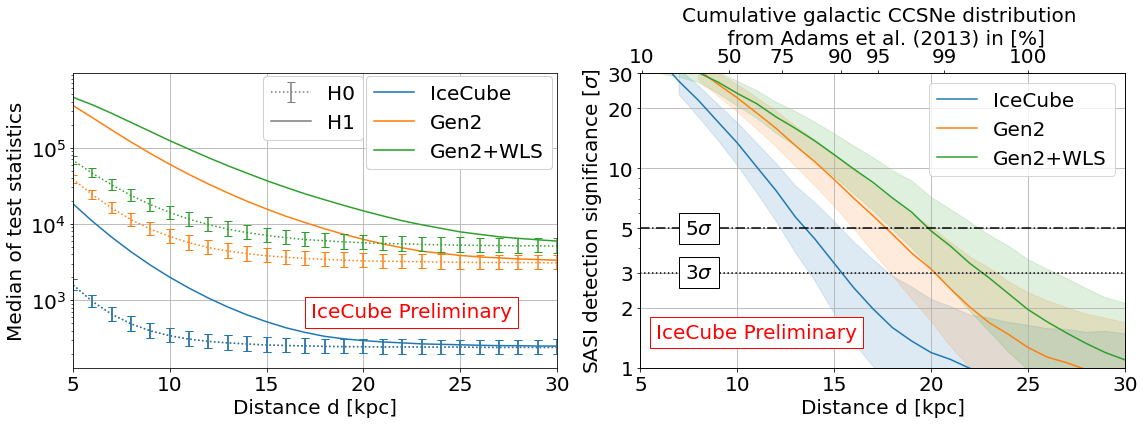

In [7]:
fig, ax = plt.subplots(1,2, figsize = (16,6))
ax = ax.ravel()
fs = 20

ax[1].plot(distances1, Z1_ic86.T[0], color = 'C0', label='IceCube')
ax[1].plot(distances1, Z1_gen2.T[0], color = 'C1', label='Gen2')
ax[1].plot(distances1, Z2_gen2.T[0], color = 'C2', label='Gen2+WLS')

ax[1].fill_between(distances1.value, Z1_ic86.T[2], Z1_ic86.T[1], alpha = 0.15, color = 'C0')
ax[1].fill_between(distances1.value, Z1_gen2.T[2], Z1_gen2.T[1], alpha = 0.15, color = 'C1')
ax[1].fill_between(distances1.value, Z2_gen2.T[2], Z2_gen2.T[1], alpha = 0.15, color = 'C2')

ax[1].set_xlabel('Distance d [kpc]', fontsize = fs)
ax[1].set_ylabel(r'SASI detection significance [$\sigma$]' , fontsize = fs)
ax[1].set_xlim((5,30))
ax[1].set_ylim((1,30))

ax[1].tick_params(labelsize = fs)

ax[1].set_yscale('log')
ax[1].set_xticks([5,10,15,20,25,30])
ax[1].set_xticklabels(['5','10','15','20','25','30'])
ax[1].set_yticks([1,2,3,5,10,20,30])
ax[1].set_yticklabels(['1','2','3','5','10','20','30'])

ax[1].grid()
ax[1].legend(loc='upper right', fontsize = fs)

ax[1].axhline(3, color='k', ls = ':')
ax[1].axhline(5, color='k', ls = '-.')
ax[1].text(8, 3, r"3$\sigma$", size=fs,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax[1].text(8, 5, r"5$\sigma$", size=fs,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax[1].text(11, 1.5, r"IceCube Preliminary", size=20,
         ha="center", va="center", color = "red",
         bbox=dict(boxstyle="square", ec='red', fc='white', alpha = 1), zorder = 30)


rates = np.array([0.1,0.5,0.75,0.9,0.95,0.99,1])
ax22 = ax[1].twiny()
ax22.set_xlim(ax[1].get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = fs)
ax22.set_xlabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = fs)

#signal without errorbar
p0, = ax[0].plot(0, Sts1_ic86.T[0][0], color = 'grey', label='H1')
p1, = ax[0].plot(distances1, Sts1_ic86.T[0], color = 'C0', label='IceCube')
p2, = ax[0].plot(distances1, Sts1_gen2.T[0], color = 'C1', label='Gen2')
p3, = ax[0].plot(distances2, Sts2_gen2.T[0], color = 'C2', label='Gen2+WLS')

#background with errorbar
p4 = ax[0].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'grey', ls = ':', label='H0')
ax[0].errorbar(x=distances1, y=Bts1_ic86.T[0],yerr=(Bts1_ic86.T[0]-Bts1_ic86.T[1],Bts1_ic86.T[2]-Bts1_ic86.T[0]), 
               capsize=4, color = 'C0', ls = ':', label=r'TS$^{bkg}_{IceCube}$')
ax[0].errorbar(x=distances1, y=Bts1_gen2.T[0],yerr=(Bts1_gen2.T[0]-Bts1_gen2.T[1],Bts1_gen2.T[2]-Bts1_gen2.T[0]), 
               capsize=4, color = 'C1', ls = ':', label=r'TS$^{bkg}_{Gen2}$')
ax[0].errorbar(x=distances2, y=Bts2_gen2.T[0],yerr=(Bts2_gen2.T[0]-Bts2_gen2.T[1],Bts2_gen2.T[2]-Bts2_gen2.T[0]), 
               capsize=4, color = 'C2', ls = ':', label=r'TS$^{bkg}_{Gen2+WLS}$')

#rearrange legend handels
handles,labels = ax[0].get_legend_handles_labels()

handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]

ax[0].set_xticks([5,10,15,20,25,30])
ax[0].set_xticklabels(['5','10','15','20','25','30'])
ax[0].set_xlabel('Distance d [kpc]', fontsize = fs)
ax[0].set_ylabel('Median of test statistics', fontsize = fs)
ax[0].set_xlim((5,30))
ax[0].set_yscale('log')
ax[0].tick_params(labelsize = fs)
#ax[0].legend(handles, labels, ncol = 3, fontsize = fs, bbox_to_anchor=(0.13, 1))
ax[0].grid()
ax[0].text(22.5, 7E2, r"IceCube Preliminary", size=20,
         ha="center", va="center", color = "red",
         bbox=dict(boxstyle="square", ec='red', fc='white', alpha = 1), zorder = 30)



l1 = fig.legend([p1, p2, p3], ['IceCube','Gen2', 'Gen2+WLS'], numpoints=1, 
                handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=fs, loc = (0.32,0.6))
l1 = plt.gca().add_artist(l1)
l2 = fig.legend([p4, p0], ['H0', 'H1'], numpoints=1,
               handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=fs , loc = (0.23,0.668))
l2 = plt.gca().add_artist(l2)



plt.tight_layout()

filename = './plots/result_taup_prelim.pdf'
plt.savefig(filename, dpi = 200, facecolor = 'white')

In [90]:
#write results into txt file

filename = './logs/freq_'+smodel+'_dir='+str(sdir)+'_mix='+smix+'_hierarchy='+shier+'_time'+stime+'_freq'+sfreq+'_IC86+Gen2+WLS.txt' 
with open(filename, 'a') as f:
    for sig in [3,5]:
        print("{} sigma detection level".format(sig), file=f)
        for det in ["wls", "gen2", "ic86"]:
            print(det, file=f)
            if det == "wls":
                funcs = [sig_wls_14, sig_wls_50, sig_wls_86]
            elif det == "gen2":
                funcs = [sig_gen2_14, sig_gen2_50, sig_gen2_86]
            elif det == "ic86":
                funcs = [sig_ic86_14, sig_ic86_50, sig_ic86_86]

            dist, perc = [], []
            for func in funcs:
                xini = 5
                loss = 1
                while loss > 1E-3:
                    res = minimize(MSE, x0=xini)
                    loss = res.fun
                    xini += 1
                    if xini > 20:
                        print('Minimization did not converge')
                        break
                dist.append(res.x)
                if res.x >= 25:
                    perc.append(np.array([1]))
                else:
                    perc.append(sd_ccsn(res.x))
            dist = np.concatenate(dist)
            perc = np.concatenate(perc)*100
            print("Distance: ({:.1f}+{:.1f}-{:.1f}) kpc".format(dist[1], dist[2]-dist[1], dist[1]-dist[0]), file=f)
            print("Coverage: ({:.1f}+{:.1f}-{:.1f}) % \n".format(perc[1], perc[2]-perc[1], perc[1]-perc[0]), file=f)

In [9]:
vanilla_ic86 = np.array([[15.3,1.6,2.5],[13.6,1.3,1.7]])
vanilla_gen2 = np.array([[20.2,2.3,3.2],[17.7,1.7,2.4]])
vanilla_wls = np.array([[22.6,2.4,3.7],[19.9,1.9,2.6]])


freqdep_ic86 = np.array([[17.1,2.6,4.3],[13.8,1.5,2.6]])
freqdep_gen2 = np.array([[22.4,3.2,5.5],[18.1,1.9,3.2]])
freqdep_wls = np.array([[25.3,3.7,6.3],[20.4,2.5,3.6]])


timedep_ic86 = np.array([[17.5,1.9,3.0],[15.7,1.5,2.0]])
timedep_gen2 = np.array([[22.9,2.3,3.9],[20.7,1.9,2.4]])
timedep_wls = np.array([[26.0,2.7,4.3],[23.5,2.3,2.7]])


freqtimedep_ic86 = np.array([[21.5,3.5,5.9],[18.5,2.3,3.4]])
freqtimedep_gen2 = np.array([[28.2,4.2,8.2],[24.4,3.1,4.6]])
freqtimedep_wls = np.array([[32.0,4.9,9.4],[27.6,3.4,5.3]])


compex_ic86 = np.array([[9.9,1.3,1.9],[8.4,1.1,1.5]])
compex_gen2 = np.array([[12.8,1.7,2.5],[10.9,1.5,1.8]])
compex_wls = np.array([[14.2,2.1,2.9],[11.8,1.7,2.2]])


mswnh_ic86 = np.array([[13.9,1.5,2.3],[12.2,1.2,1.6]])
mswnh_gen2 = np.array([[18.1,2.0,2.8],[15.9,1.6,2.2]])
mswnh_wls = np.array([[20.4,2.3,3.4],[17.8,1.9,2.5]])


mswih_ic86 = np.array([[10.0,1.3,2.0],[8.6,1.1,1.4]])
mswih_gen2 = np.array([[13.0,1.7,2.4],[11.0,1.5,1.9]])
mswih_wls = np.array([[14.4,2.0,3.0],[12.0,1.8,2.3]])


m27d1_ic86 = np.array([[10.8,1.1,1.9],[9.3,0.7,1.1]])
m27d1_gen2 = np.array([[13.8,1.3,2.2],[11.8,1.0,1.3]])
m27d1_wls = np.array([[15.4,1.6,2.5],[13.2,1.2,1.5]])


m27d2_ic86 = np.array([[9.9,1.1,1.7],[8.4,0.7,1.1]])
m27d2_gen2 = np.array([[12.6,1.3,2.1],[10.8,0.9,1.5]])
m27d2_wls = np.array([[14.0,1.4,2.4],[12.0,1.3,1.5]])


m27d3_ic86 = np.array([[9.5,1.0,1.7],[8.2,0.8,1.0]])
m27d3_gen2 = np.array([[12.1,1.2,1.9],[10.5,1.0,1.3]])
m27d3_wls = np.array([[13.5,1.4,2.3],[11.5,1.1,1.6]])

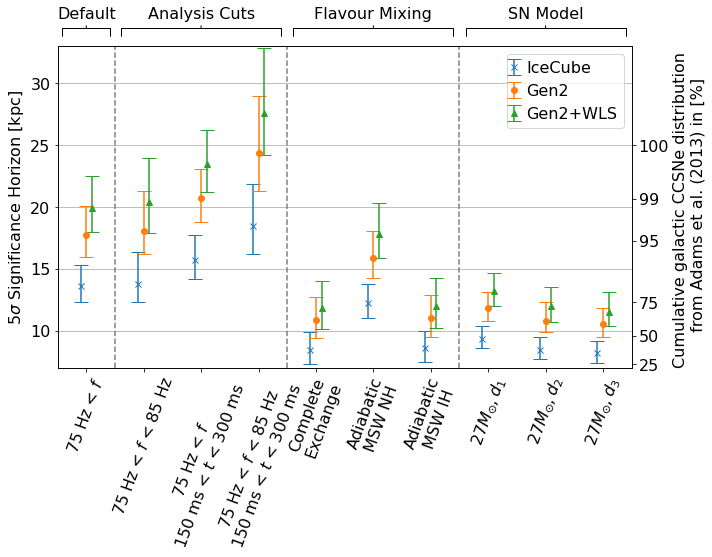

In [10]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fs = 16

fig, ax = plt.subplots(1,1, figsize = (10,8))
xlabels = [r'75 Hz < $f$', r'75 Hz < $f$ < 85 Hz', '75 Hz < $f$\n150 ms < $t$ < 300 ms', '75 Hz < $f$ < 85 Hz\n150 ms < $t$ < 300 ms', 
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']

ax.errorbar(x=-0.1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=0, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=0.1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(0.5, color = 'grey', ls = '--')


ax.errorbar(x=0.9, y=freqdep_ic86[1][0], yerr=freqdep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=1, y=freqdep_gen2[1][0], yerr=freqdep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=1.1, y=freqdep_wls[1][0], yerr=freqdep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=1.9, y=timedep_ic86[1][0], yerr=timedep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=2, y=timedep_gen2[1][0], yerr=timedep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=2.1, y=timedep_wls[1][0], yerr=timedep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=2.9, y=freqtimedep_ic86[1][0], yerr=freqtimedep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=3, y=freqtimedep_gen2[1][0], yerr=freqtimedep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=3.1, y=freqtimedep_wls[1][0], yerr=freqtimedep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(3.5, color = 'grey', ls = '--')

ax.errorbar(x=3.9, y=compex_ic86[1][0], yerr=compex_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=4, y=compex_gen2[1][0], yerr=compex_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=4.1, y=compex_wls[1][0], yerr=compex_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=4.9, y=mswnh_ic86[1][0], yerr=mswnh_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=5, y=mswnh_gen2[1][0], yerr=mswnh_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=5.1, y=mswnh_wls[1][0], yerr=mswnh_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=5.9, y=mswih_ic86[1][0], yerr=mswih_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=6, y=mswih_gen2[1][0], yerr=mswih_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=6.1, y=mswih_wls[1][0], yerr=mswih_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(6.5, color = 'grey', ls = '--')

ax.errorbar(x=6.9, y=m27d1_ic86[1][0], yerr=m27d1_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=7, y=m27d1_gen2[1][0], yerr=m27d1_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=7.1, y=m27d1_wls[1][0], yerr=m27d1_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=7.9, y=m27d2_ic86[1][0], yerr=m27d2_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=8, y=m27d2_gen2[1][0], yerr=m27d2_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=8.1, y=m27d2_wls[1][0], yerr=m27d2_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=8.9, y=m27d3_ic86[1][0], yerr=m27d3_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=9, y=m27d3_gen2[1][0], yerr=m27d3_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=9.1, y=m27d3_wls[1][0], yerr=m27d3_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=-1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax.errorbar(x=-1, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax.errorbar(x=-1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax.tick_params(labelsize = fs)
ax.grid(axis='y')
ax.set_xticks(np.arange(10), labels = xlabels, rotation = 70, fontsize = fs)
ax.set_xlim(-0.5,9.5)
ax.set_ylim(7,33)

ax.set_ylabel(r'$5\sigma$ Significance Horizon [kpc]', fontsize=fs)
ax.legend(loc = 'upper right', fontsize=fs)

rates = np.array([0.25,0.5,0.75,0.95,0.99,1])
ax22 = ax.twinx()
ax22.set_ylim(ax.get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = fs)
ax22.set_ylabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = fs)


ax.annotate('Default', xy=(0.05, 1.05), xytext=(0.05, 1.1), xycoords='axes fraction', 
            fontsize=fs, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Analysis Cuts', xy=(0.25, 1.05), xytext=(0.25, 1.1), xycoords='axes fraction', 
            fontsize=fs, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Flavour Mixing', xy=(0.55, 1.05), xytext=(0.55, 1.1), xycoords='axes fraction', 
            fontsize=fs, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('SN Model', xy=(0.85, 1.05), xytext=(0.85, 1.1), xycoords='axes fraction', 
            fontsize=fs, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))


plt.tight_layout()
plt.savefig('./plots/systematics_taup.pdf', dpi = 200)

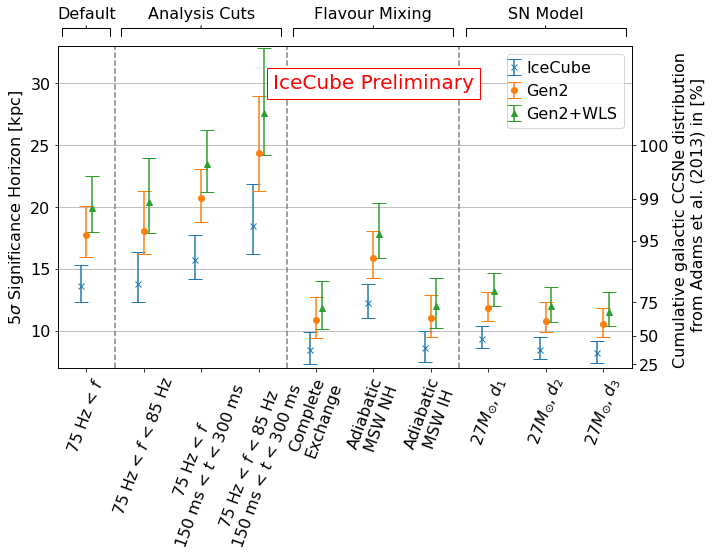

In [11]:
mpl.rcParams['legend.handlelength'] = 0
mpl.rcParams['legend.markerscale'] = 1

fs = 16

fig, ax = plt.subplots(1,1, figsize = (10,8))
xlabels = [r'75 Hz < $f$', r'75 Hz < $f$ < 85 Hz', '75 Hz < $f$\n150 ms < $t$ < 300 ms', '75 Hz < $f$ < 85 Hz\n150 ms < $t$ < 300 ms', 
           'Complete\nExchange', 'Adiabatic\nMSW NH', 'Adiabatic\nMSW IH', 
           r'$27 M_{\odot}, d_1$', r'$27 M_{\odot}, d_2$', r'$27 M_{\odot}, d_3$']

ax.errorbar(x=-0.1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=0, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=0.1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(0.5, color = 'grey', ls = '--')


ax.errorbar(x=0.9, y=freqdep_ic86[1][0], yerr=freqdep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=1, y=freqdep_gen2[1][0], yerr=freqdep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=1.1, y=freqdep_wls[1][0], yerr=freqdep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=1.9, y=timedep_ic86[1][0], yerr=timedep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=2, y=timedep_gen2[1][0], yerr=timedep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=2.1, y=timedep_wls[1][0], yerr=timedep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=2.9, y=freqtimedep_ic86[1][0], yerr=freqtimedep_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=3, y=freqtimedep_gen2[1][0], yerr=freqtimedep_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=3.1, y=freqtimedep_wls[1][0], yerr=freqtimedep_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(3.5, color = 'grey', ls = '--')

ax.errorbar(x=3.9, y=compex_ic86[1][0], yerr=compex_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=4, y=compex_gen2[1][0], yerr=compex_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=4.1, y=compex_wls[1][0], yerr=compex_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=4.9, y=mswnh_ic86[1][0], yerr=mswnh_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=5, y=mswnh_gen2[1][0], yerr=mswnh_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=5.1, y=mswnh_wls[1][0], yerr=mswnh_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=5.9, y=mswih_ic86[1][0], yerr=mswih_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=6, y=mswih_gen2[1][0], yerr=mswih_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=6.1, y=mswih_wls[1][0], yerr=mswih_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.axvline(6.5, color = 'grey', ls = '--')

ax.errorbar(x=6.9, y=m27d1_ic86[1][0], yerr=m27d1_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=7, y=m27d1_gen2[1][0], yerr=m27d1_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=7.1, y=m27d1_wls[1][0], yerr=m27d1_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=7.9, y=m27d2_ic86[1][0], yerr=m27d2_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=8, y=m27d2_gen2[1][0], yerr=m27d2_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=8.1, y=m27d2_wls[1][0], yerr=m27d2_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=8.9, y=m27d3_ic86[1][0], yerr=m27d3_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0')
ax.errorbar(x=9, y=m27d3_gen2[1][0], yerr=m27d3_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1')
ax.errorbar(x=9.1, y=m27d3_wls[1][0], yerr=m27d3_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2')

ax.errorbar(x=-1, y=vanilla_ic86[1][0], yerr=vanilla_ic86[1][1:].reshape(-1,1), capsize=7, marker = 'x', color = 'C0', label = 'IceCube')
ax.errorbar(x=-1, y=vanilla_gen2[1][0], yerr=vanilla_gen2[1][1:].reshape(-1,1), capsize=7, marker = 'o', color = 'C1', label = 'Gen2')
ax.errorbar(x=-1, y=vanilla_wls[1][0], yerr=vanilla_wls[1][1:].reshape(-1,1), capsize=7, marker = '^', color = 'C2', label = 'Gen2+WLS')


ax.tick_params(labelsize = fs)
ax.grid(axis='y')
ax.set_xticks(np.arange(10), labels = xlabels, rotation = 70, fontsize = fs)
ax.set_xlim(-0.5,9.5)
ax.set_ylim(7,33)

ax.set_ylabel(r'$5\sigma$ Significance Horizon [kpc]', fontsize=fs)
ax.legend(loc = 'upper right', fontsize=fs)

rates = np.array([0.25,0.5,0.75,0.95,0.99,1])
ax22 = ax.twinx()
ax22.set_ylim(ax.get_ylim())
ax22.set_yticks(inv_cdf(rates).flatten())
ax22.set_yticklabels((rates*100).astype(dtype=int), rotation = 0, fontsize = fs)
ax22.set_ylabel('Cumulative galactic CCSNe distribution \n from Adams et al. (2013) in [%]', fontsize = fs)


ax.annotate('Default', xy=(0.05, 1.05), xytext=(0.05, 1.1), xycoords='axes fraction', 
            fontsize=fs, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Analysis Cuts', xy=(0.25, 1.05), xytext=(0.25, 1.1), xycoords='axes fraction', 
            fontsize=fs, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('Flavour Mixing', xy=(0.55, 1.05), xytext=(0.55, 1.1), xycoords='axes fraction', 
            fontsize=fs, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))

ax.annotate('SN Model', xy=(0.85, 1.05), xytext=(0.85, 1.1), xycoords='axes fraction', 
            fontsize=fs, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=5.0, lengthB=0.5', lw=1.0, color='k'))

ax.text(5, 30, r"IceCube Preliminary", size=20,
         ha="center", va="center", color = "red",
         bbox=dict(boxstyle="square", ec='red', fc='white', alpha = 1), zorder = 30)


plt.tight_layout()
plt.savefig('./plots/systematics_taup_prelim.pdf', dpi = 200)